In [1]:
# from http://helios.fmi.fi/~lainema/dlm/dlmtut.html

# Dynamic linear models

This text gives an introduction to using state space based dynamic regression analysis of time series. We are especially interested in extracting trends in climatic observations. The computer examples are given using my DLM toolbox for Matlab.

## Introduction

Statistical analysis of time series data is usually faced with the fact that we have only one realization of a process whose properties we might not fully understand. In analysis of correlation structures, for example, we need to assume that some distributional properties of the process generating the variability stay unchanged in time. In linear trend analysis, we assume that there is an underlying change in the background that stays approximately constant over time. Dynamic regression with state space approach tries to avoid some of the problems. By explicitly allowing for variability in the regression coefficients we let the system properties change in time. Furthermore, the use of unobservable state variables allows direct modelling of the processes that are driving the observed variability, such as seasonality or external forcing, and we can explicitly allow for some modelling error.

Dynamic regression can in very general terms be formulated using state space representation of the of the observations and the state of the system. With a sequential definition of the processes, having conditional dependence only on the previous time step, the classical Kalman filter formulas can be used to estimates the states given the observations. When the operators involved in the definition of the system are linear we have so called dynamic linear model, DLM.

A basic model for many climatic time series consist of four elements: slowly varying background level, seasonal component, external forcing of known processes modelled by proxy variables, and stochastic noise. The noise components might contain an autoregressive correlation structure to account for correlated model residuals. However, autocorrelated errors can be problematic as they might be caused by a long memory of the process as well as by some systematic features not included in the model.

This is a short tutorial on using dynamic linear models in time series analysis. It is based on my attempts to analyse some climatic time series. For that purposes I wrote the Matlab code described here. The examples deal with univariate time series, but the code can handle multivariate data, to some extent. Here we are mostly interested in extracting the components, and using these to infer about some interesting features of the system, but not to produce predictions about the behaviour of the system in the future, although understanding the system is a first step to be able to make predictions.

The use of DLMs in time series analysis is well documented in statistical literature, see the references at the end.

## State space description

General dynamic linear model can be written with a help of observation equation and model equation as

$
y_t=F_i x_t + \nu_t, \nu_t \sim N(9,V_t) \\
x_t=G_t x_{t-1} + w_t, w_t \sim N(0, W_t) 
$

Above yt are the observations at time t, with t=1,…,n. Vector $x_t$ of length m contains the unobserved states of the system that are assumed to evolve in time according to a linear system operator Gt (a m×m matrix). In time series settings xt will have elements corresponding to various components of the time series process, like trend, seasonality, etc. We observe a linear combination of the states with noise and matrix Ft (m×p) is the observation operator that transforms the model states into observations. Both observation end system equations can have additive Gaussian errors with covariance matrices Vt and Wt.

This formulation is quite general and flexible and it allows handling of many time series analysis problems in a single framework. Moreover, an unified computational tool can be used, i.e. a single DLM computer code can be used for various purposes. Below we give examples of different analyses. As we are dealing with linear models, we assume that the operators Gt and Ft are linear, i.e. matrices. However, they can change with the time index t. The state space framework can be extended to non linear model and non Gaussian errors, and to spatial-temporal analyses as well, see, e.g., Cressie.

## DLM as hierarchical statistical model

The DLM formulation can be seen as special case of a general hierarchical statistical model with three levels: data, process and parameters (see e.g. Cressie). In terms of statistical distributions we have, first, the observations uncertainty p(yt∣∣xt,θ) described by the observation equation. Second, the process uncertainty of the unknown states xt and their evolution given by the process equations as p(xt∣∣θ), and third, the uncertainty related to model parameters p(θ). These conditional formulations allows both efficient description of the system and computational tools to estimate its components. It also combines different statistical approaches, as we can have full prior probabilities for the unknowns (Bayesian approach), estimate them by maximum likelihood and plug them back (frequentistic approach), or even fix the model parameters by expert knowledge (a trivial non statistical approach).

## State and parameter estimation

Recall that yt are the observations and xt the hidden system states for t=1,…,n. In addition, we have (static) model parameter θ that contains auxiliary parameters needed in defining the model and observation errors Wt and Vt and the system matrices Gt and Ft. For dynamic linear models we have efficient and well founded computational tools for all the relevant statistical distributions.

$
p(xt+1∣∣xt,y1:t,θ) by Kalman filter \\
p(xt∣∣y1:t,θ) by Kalman filter \\
p(xt∣∣y1:n,θ) by Kalman smoother \\
p(x1:n∣∣y1:n,θ) by simulation smoother \\
p(y1:t∣∣θ) by Kalman filter likelihood \\
p(x1:n,θ∣∣y1:n) by MCMC \\
p(x1:n∣∣y1:n) by MCMC 
$

In [8]:
# skip ahead to the example

import numpy as np
import spacepy.plot as spp
import pymc as mc


In [3]:
# Nile flow data
y = np.asarray([1120, 1160,  963, 1210, 1160, 1160,  813, 1230, 1370, 1140,  995,  935,
     1110,  994, 1020,  960, 1180,  799,  958, 1140, 1100, 1210, 1150, 1250,
     1260, 1220, 1030, 1100,  774,  840,  874,  694,  940,  833,  701,  916,
     692, 1020, 1050,  969,  831, 726,  456,  824,  702, 1120, 1100,  832,  764,
     821,  768,  845, 864,  862, 698,  845,  744,  796, 1040,  759,  781,  865,
     845,  944,  984,  897,  822, 1010, 771,  676,  649,  846,  812,  742,  801,
     1040,  860,  874, 848,  890,  744,  749,  838, 1050,  918,  986,  797,  923,
     975,  815, 1020,  906,  901, 1170,  912,  746,  919,  718,  714,  740])

t = np.arange(1871, 1971) #  time

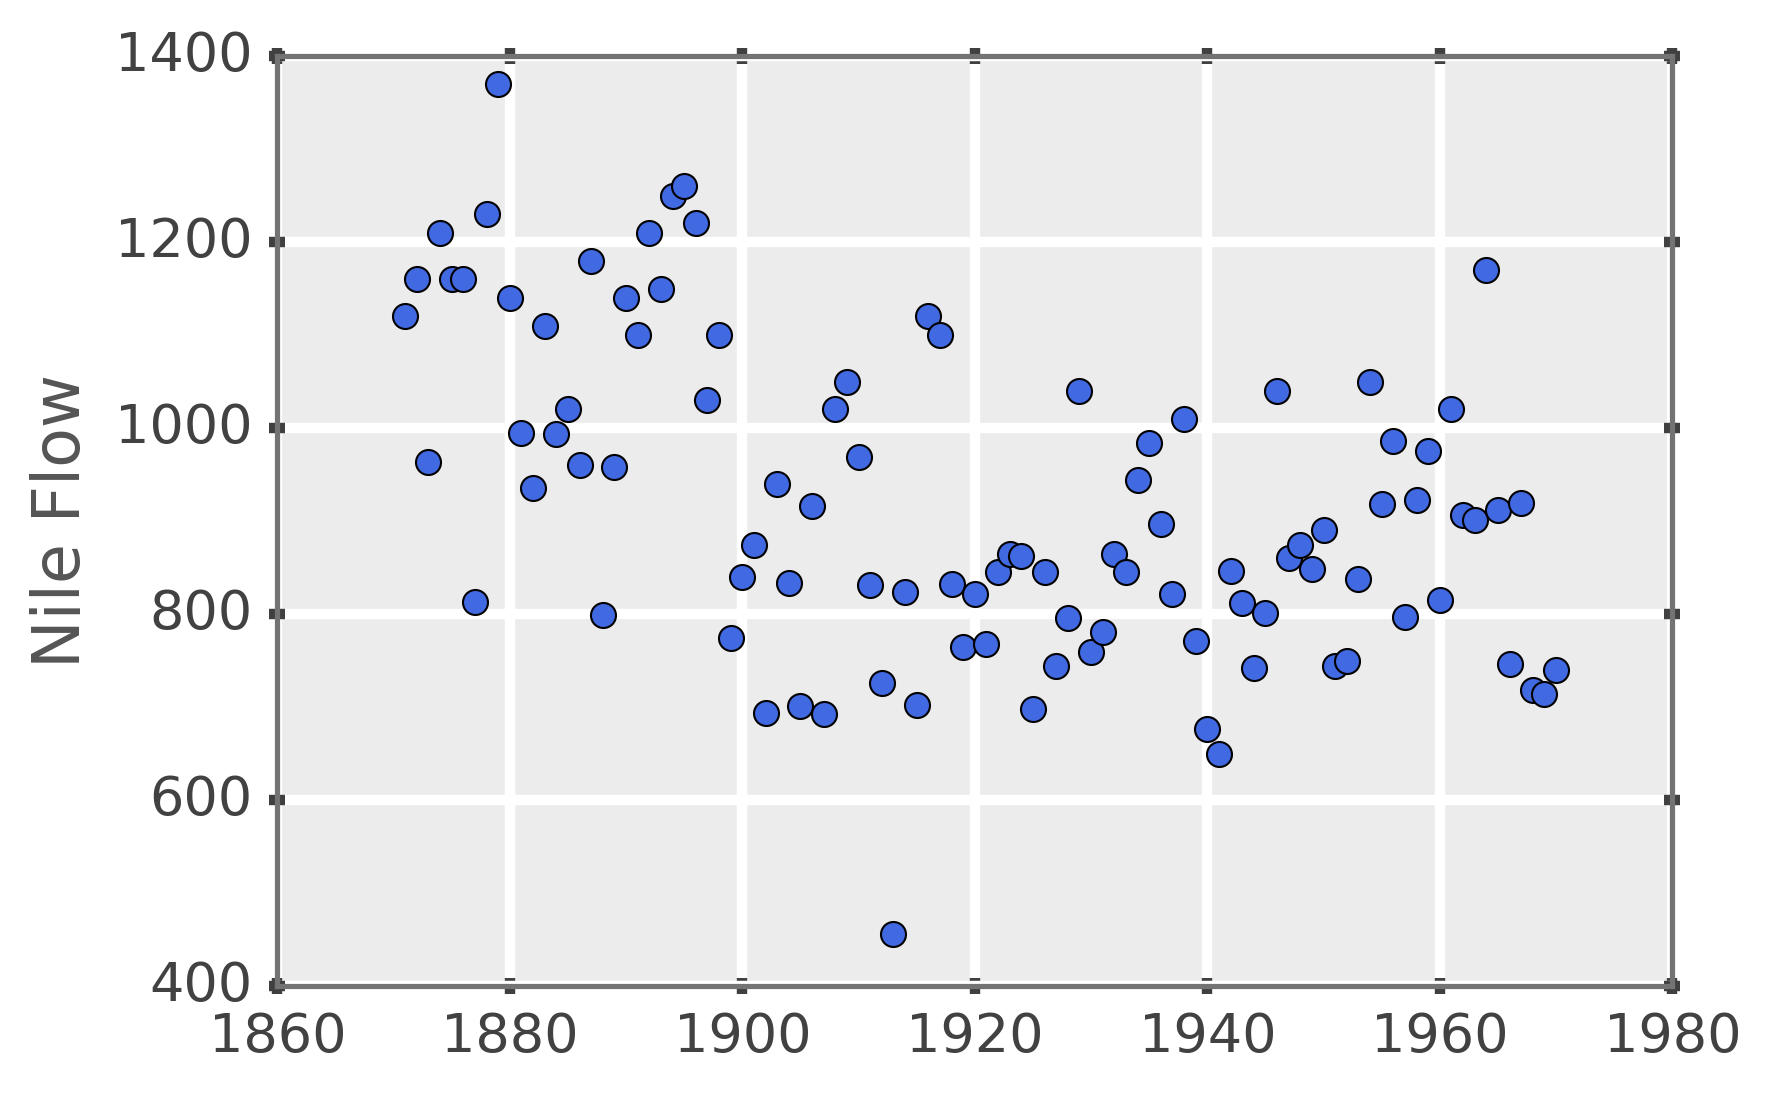

In [4]:
spp.plt.plot(t, y, 'o')
spp.plt.ylabel("Nile Flow")

# Spline smoothing


A simple level and trend model can be used as a basis for many trend related studies. In terms of local level $\mu_t$ and local trend $\alpha_{t}$ it can be written as

$y_t=\mu_t +\epsilon_{obs}$, $\epsilon_{obs} \sim N(0,\sigma^2_{obs})$, observations

$\mu_t=\mu_{t-1}+\alpha_{t-1} + \epsilon_{level}$, $\epsilon_{level} \sim N(0,\sigma^2_{level})$, local level

$\alpha_t = \alpha_{t-1} + \epsilon_{trend}$, $\epsilon_{trend} \sim N(o, \sigma^2_{trend})$, local trend

known observation uncertainty standard deviation $(\sigma_{obs}=122)$ and known level and trend variability standard deviations $([0\  1.65])$. In later examples these values are estimated from the data. The Figure 1 below shows the data together with estimated level component μ1:n=xlevel,1:n and its 95% probability envelope, formed from individual probability limits.

In [13]:
mc.deterministic?

In [15]:
eps_obs = mc.Normal('eps_obs', 0, (1/122)**2)
mu_t = mc.Uniform('mu_t', 0, 5000)
y_t = mc.Normal('y_t', mu_t, eps_obs, observed=True, value=y)



In [ ]:
eps_obs = mc.Normal

In [6]:
model = pymc.MCMC(y_m)